# Tarefa: Submeter uma predicao no Kaggle

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import umap
from collections import Counter
import re

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
#unpatch_sklearn()

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin


#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tqdm import tqdm



np.__version__, pd.__version__, sklearn.__version__, matplotlib.__version__, sns.__version__, umap.__version__

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


('1.20.3', '1.3.3', '1.0.1', '3.4.2', '0.11.2', '0.5.2')

In [35]:
from numpy import dtype

# Dataset capturado do desafio https://www.kaggle.com/c/titanic/data
df = pd.read_csv('../data/titanic/train.csv')
df_test = pd.read_csv('../data/titanic/test.csv')

y = df.Survived
X = df.drop('Survived',axis=1)
X_test = df_test
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
list(Counter(y).values())/y.count(),Counter(y)

(array([0.61616162, 0.38383838]), Counter({0: 549, 1: 342}))

In [71]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
#from sklearn.metrics import euclidean_distances
from collections import Counter
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def getInt(x):
    try: t = int(x)
    except: t = np.nan
    return t

class TitanicTransformEngFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_unused=True,ordinal_pclass=True,
                 include_feats=['AgeGroup','NameTitle','SurNameFrequency','CabinsCount',
                                'CabinsDeck','CabinsDeckMaxNumber','CabinsDeckMaxZone',
                                'CabinsDeckMinNumber','TicketType',
                                'TicketFrequency'
                                  ]):
        self.exclude_unused = exclude_unused
        self.ordinal_pclass = ordinal_pclass
        self.include_feats = include_feats 
        

    def fit(self, X, y=None):
        
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        self.features_ = X.columns
        self.X_ = X.copy()
        
        
        #Begin fitting transformer
        
        self.tobe_removed = ['PassengerId', 'Ticket', 'Cabin','Name']
        
        return self
    
    def transform(self, X, y=None):

        # Check is fit had been called
        check_is_fitted(self)
        Xs = X.copy()

        if self.ordinal_pclass: Xs['Pclass'] = pd.Categorical(Xs.Pclass,categories=[1,2,3],ordered=True)
        else: Xs['Pclass'] = Xs.Pclass.astype('object')
            
        Xs['Age'] = Xs.Age//1
        Xs['Fare'] = Xs.Fare//1
        
        if 'AgeGroup' in self.include_feats: Xs['AgeGroup'] = self.getAgeGroup(Xs.Age)

        if 'NameTitle' in self.include_feats: Xs['NameTitle'] = Xs.Name.apply(self.getTitle)
        if 'SurNameFrequency' in self.include_feats: Xs['SurNameFrequency'] = Xs.Name.apply(self.getSurNameFrequency,args=(self.X_.Name,self,))
        if 'Family' in self.include_feats: Xs['Family'] = self.getFamilies(Xs,self)    

        if 'CabinsCount' in self.include_feats: Xs['CabinsCount'] = Xs.Cabin.apply(self.getCabinsCount)
        if 'CabinsDeck' in self.include_feats: Xs['CabinsDeck'] = Xs.Cabin.apply(self.getCabinsDeck)
        if 'CabinsDeckMaxNumber' in self.include_feats: Xs['CabinsDeckMaxNumber'] = Xs.Cabin.apply(self.getCabinsDeckMaxNumber)
        if 'CabinsDeckMinNumber' in self.include_feats: Xs['CabinsDeckMinNumber'] = Xs.Cabin.apply(self.getCabinsDeckMinNumber)
        if 'CabinsDeckMaxZone' in self.include_feats: Xs['CabinsDeckMaxZone'] = Xs.Cabin.apply(self.getCabinsDeckMaxZone,args=(self,10,30,))

        if 'TicketType' in self.include_feats: Xs['TicketType'] = Xs.Ticket.apply(self.getTicketType)
        if 'TicketFrequency' in self.include_feats: Xs['TicketFrequency'] = Xs.Ticket.apply(self.getTicketFrequency,args=(self.X_.Ticket,self,))

        if self.exclude_unused: Xs = Xs.drop(self.tobe_removed,axis=1)


        return Xs
    
    #FEATURE ENG METHODS
    
    @staticmethod
    def getAgeGroup(x):
        bins = [0, 2, 12, 17, 30, 45, 60, np.inf]
        labels = ['baby', 'child', 'teen', 'young' ,'adult', 'senior' ,'elderly']
        return pd.cut(x, bins = bins, labels = labels)       
        
    @staticmethod   
    def getSurName(s):
        #return s.split(',')[0].strip()
        r = s.split(',')[0]
        l = re.findall(r'([A-Za-z]+)',r)
        r = ''.join(l).lower()
        return r

    @staticmethod
    def getSurNameFrequency( s, s_col, self):
        l = Counter(s_col.apply(self.getSurName))
        return l.get(self.getSurName(s),1)
    
    @staticmethod
    def getTitle(s):
        t = s.split(', ')[1].split('.')[0].strip()
        return {
            'Mr': 'Married man',
            'Mrs': 'Married woman',
            'Master': 'Single man',
            'Miss': 'Single woman',
            'Ms': 'Single woman',
            'Lady': 'Single woman',
            'Jonkheer': 'Married man',
            'Major': 'Oficial',
            'Dr': 'Oficial',
            'Col': 'Oficial',
            'Capt': 'Oficial',
            'Cap': 'Oficial',
            'Oficial': 'Oficial',
        }.get(t,'NA')
    
    @staticmethod
    def getCabinsCount(s):
        if isinstance(s, str): t = len(s.split(' '))#.notnull().sum(axis=1)
        else: t = 0
        return int(t)


    
    @staticmethod
    def getCabinsDeck(s):
        if isinstance(s, str): 
            l = s.split(' ')
            x = np.array([(x[0],x[1:]) for x in l])
            t = sorted(x[:,0])[-1]

        else: t = 'NA'

        return t
    
    @staticmethod
    def getCabinsDeckMaxNumber(s):
        if isinstance(s, str): 
            l = s.split(' ')
            l = np.array([(x[0],x[1:]) for x in l])
            l = l[:,1]
            l = np.array([getInt(x) for x in l])
            l = np.nan_to_num(l,nan=-np.inf)
            t = l[l.argmax()]
            try: t = int(t)
            except: t= -1

        else: t = -1

        return int(t)
    
    @staticmethod
    def getCabinsDeckMaxZone(s,self,lowcut=10,midcut=40):
        n = self.getCabinsDeckMaxNumber(s)
        if n <= 0 : return('NA')
        if n <= lowcut: return('low')
        if n <= midcut: return('mid')
        else: return('high')
    
    @staticmethod
    def getCabinsDeckMinNumber(s):
        if isinstance(s, str): 
            l = s.split(' ')
            l = np.array([(x[0],x[1:]) for x in l])
            l = l[:,1]
            l = np.array([getInt(x) for x in l])
            l = np.nan_to_num(l,nan=np.inf)
            t = l[l.argmin()]
            try: t = int(t)
            except: t= -1

        else: t = -1

        return int(t) 
    
    @staticmethod
    def getTicketType(s):
        l = re.findall('([a-zA-Z]+)',s)
        r = ''.join(l).upper()
        return r
    
    @staticmethod
    def getTicketNumber(s):
        l = re.findall(r'\b\d+\b',s)
        r = ''.join(l).upper()
        return r

    @staticmethod
    def getTicketFrequency( s, s_col, self):
        l = Counter(s_col.apply(self.getTicketNumber))
        return l.get(self.getTicketNumber(s),1)
    
    @staticmethod
    def getFamilies(X,self):
        x = X.Name.apply(self.getSurName)+ X.Ticket.apply(self.getTicketNumber)
        return x
  




## Teste de transformação e visualização das features vs Survived

In [72]:
aux = TitanicTransformEngFeatures().fit_transform(X)
display(aux.describe(include='all').T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Pclass,891.0,3.0,3.0,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.679272,14.536483,0.0,20.0,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Fare,891.0,NaN,NaN,NaN,31.785634,49.70373,0.0,7.0,14.0,31.0,512.0
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeGroup,707,7,young,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NameTitle,891,6,Married man,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SurNameFrequency,891.0,NaN,NaN,NaN,1.882155,1.488014,1.0,1.0,1.0,2.0,9.0


<AxesSubplot:xlabel='SurNameFrequency', ylabel='Survived'>

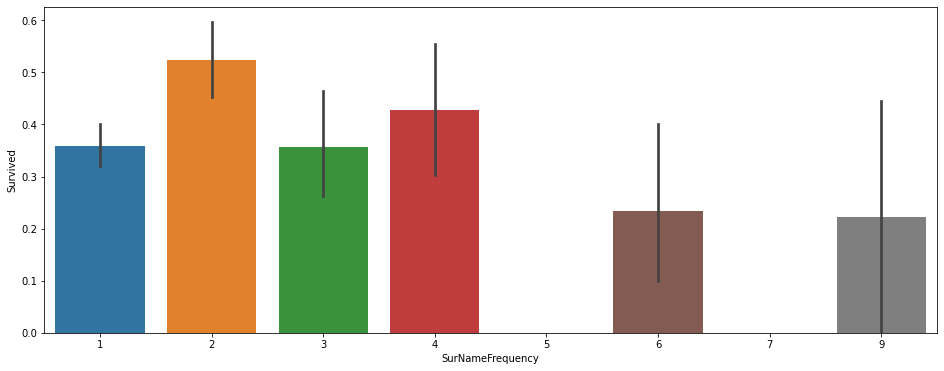

In [73]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="SurNameFrequency", y="Survived",data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='TicketFrequency', ylabel='Survived'>

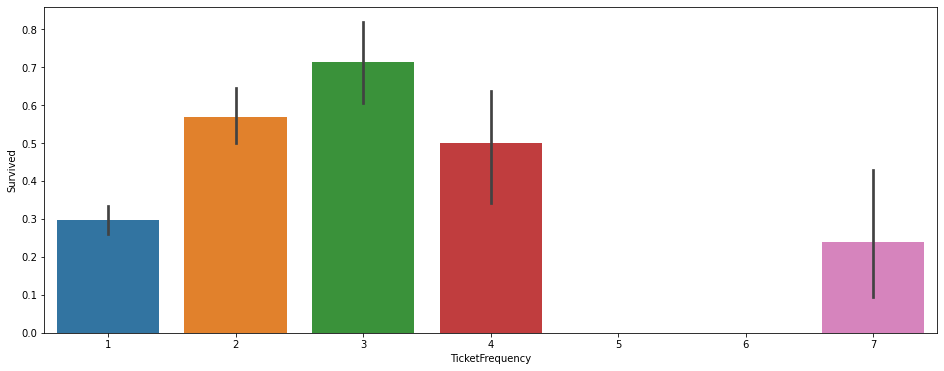

In [74]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="TicketFrequency", y="Survived", data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='CabinsDeck', ylabel='Survived'>

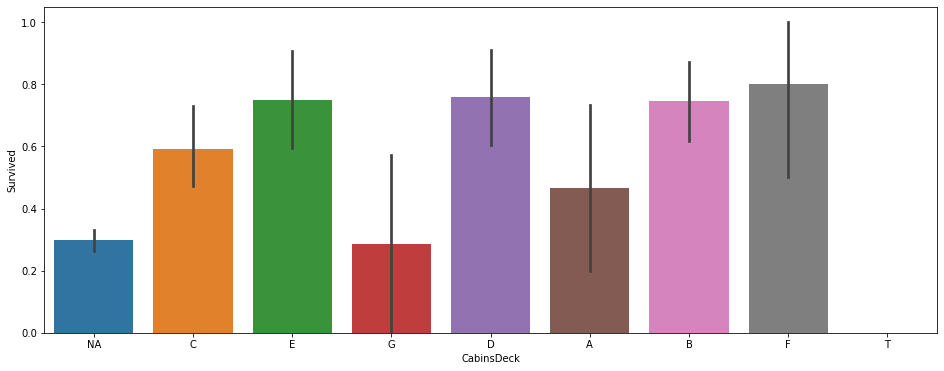

In [75]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="CabinsDeck", y="Survived", data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='CabinsCount', ylabel='Survived'>

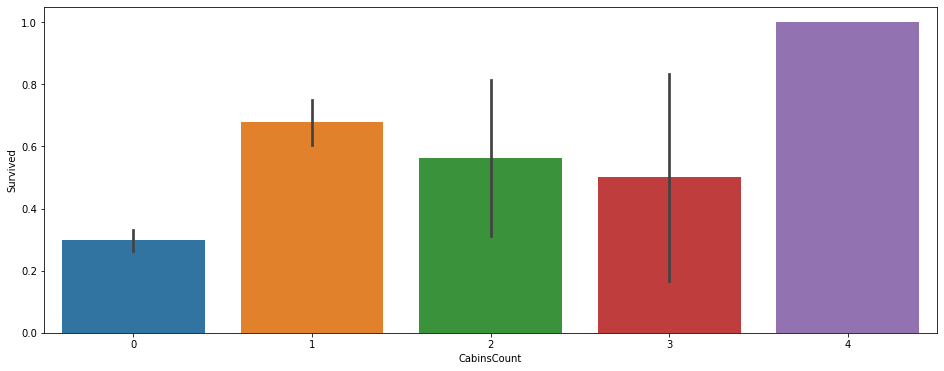

In [76]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="CabinsCount", y="Survived", data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

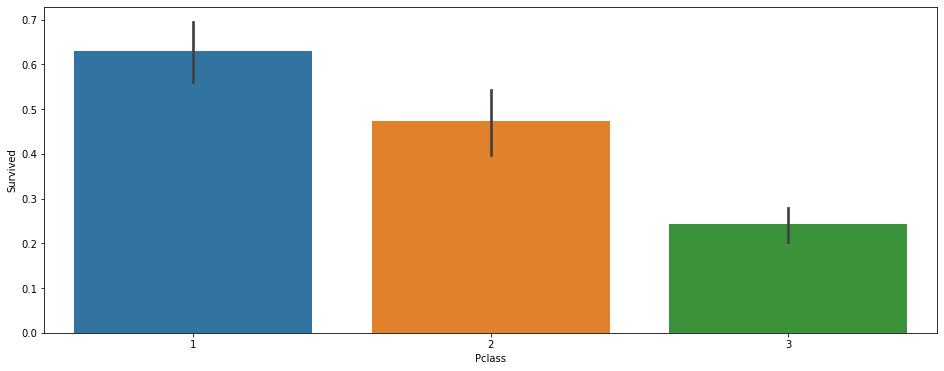

In [77]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="Pclass", y="Survived", data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='AgeGroup', ylabel='Survived'>

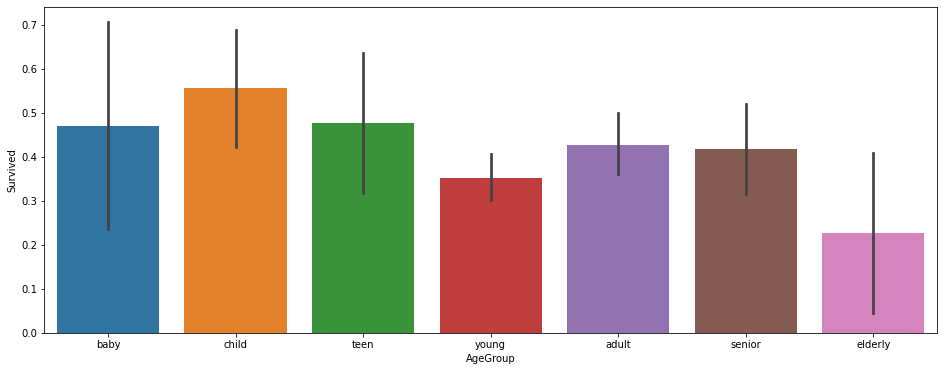

In [78]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="AgeGroup", y="Survived", data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

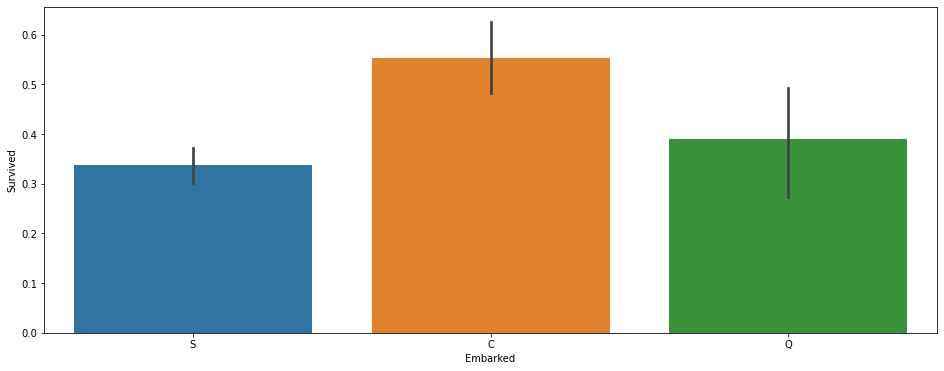

In [79]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="Embarked", y="Survived", data=aux.join(y),ax=ax)

<AxesSubplot:xlabel='NameTitle', ylabel='Survived'>

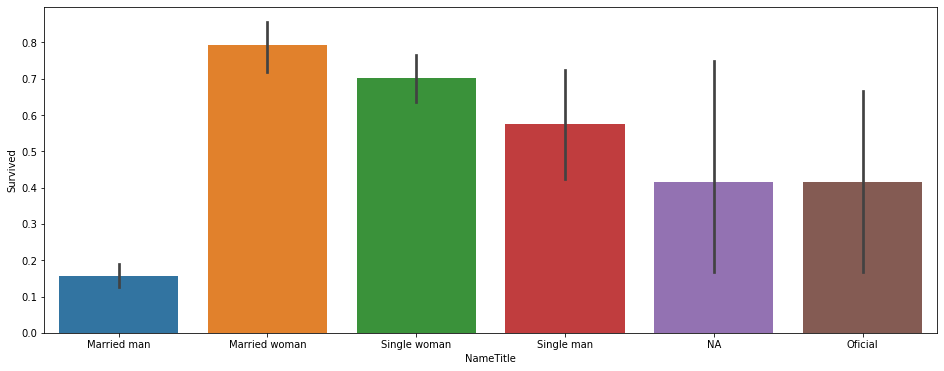

In [80]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="NameTitle", y="Survived",  data=aux.join(y),ax=ax)

In [81]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer

class AtributosNumericos(BaseEstimator, TransformerMixin):
    def __init__(self ,imputer=SimpleImputer(strategy='median')):
        self.feature_names_in_ = None
        self.colunasNumericas = None
        self.imputer = imputer
        self.enc = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
                             ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))
                            ])
    
    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        
        self.n_features_in_ = len(X.columns)
        self.feature_names_in_ = X.columns
        
        self.colunasNumericas = X.select_dtypes(include='number').columns
        self.colunasCategoricas = X.select_dtypes(exclude='number').columns
        
        self.enc.fit(X[self.colunasCategoricas].to_numpy())
        self.imputer.fit(X[self.colunasNumericas].join(pd.DataFrame(self.enc.transform(X[self.colunasCategoricas].to_numpy()))).to_numpy())
        
        return self
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        #print(self.colunasNumericas)
        
        #Xs = X.copy()
        Xs = self.imputer.transform( X[self.colunasNumericas].join(
            pd.DataFrame(self.enc.transform( X[self.colunasCategoricas].to_numpy() )) ).to_numpy() )
        
        return Xs[:,:X[self.colunasNumericas].shape[1]]

#pd.DataFrame(AtributosNumericos().fit_transform(TitanicTransformEngFeatures().fit_transform(X)))
TitanicTransformEngFeatures().fit_transform(X)

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
    def __init__(self ):
        self.feature_names_in_ = None
        self.colunasCategoricas = None

    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        
        self.n_features_in_ = len(X.columns)
        self.feature_names_in_ = X.columns
        
        #print('MEGABUG', X.columns)
        
        self.colunasCategoricas = X.select_dtypes(exclude='number').columns
        return self
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        
        return X[self.colunasCategoricas].to_numpy()

In [154]:
from sklearn.base import BaseEstimator, TransformerMixin


class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self ,corr_tresh = 0.99, method='pearson'):
        self.corr_tresh = corr_tresh
        self.method = method
        self.high_corr_ = []
        self.fitted_numpy_ = False

    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): 
            Xs = pd.DataFrame(X)
            self.fitted_numpy_ = True
        else: 
            Xs = X
            
        
        self.high_corr_ = self.correlated_features(Xs,self.corr_tresh,self.method)
        return self
    
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        if not isinstance(X, pd.DataFrame): 
            if self.fitted_numpy_ :
                Xs = pd.DataFrame(X)
            else:
                raise Exception('Fit() wasnt a numpy array')
        else: 
            if self.fitted_numpy_: 
                Xs=pd.DataFrame(X.to_numpy())
            else:
                Xs=X
            
        Xs = Xs.drop(self.high_corr_,axis=1)
        
        return Xs.to_numpy()
    
    @staticmethod
    def correlated_features(X, corr_tresh = 0.99,method='pearson'):
        """
        Identifies features that are highly correlated. Let's assume that if
        two features or more are highly correlated, we can randomly select
        one of them and discard the rest without losing much information.


        Parameters
        ----------
        X : pandas dataframe
            A data set where each row is an observation and each column a feature.

        correlation_threshold: float, optional (default = 0.99)
            The threshold used to identify highly correlated features.

        Returns
        -------
        labels: list
            A list with the labels identifying the features that contain a 
            large fraction of constant values.
        """

        # Make correlation matrix
        corr_matrix = X.corr(method = method).abs()


        # Select upper triangle of matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

        # Find index of feature columns with correlation greater than correlation_threshold
        labels = [column for column in upper.columns if any(upper[column] >  corr_tresh)]

        return labels

In [233]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.feature_selection import RFECV,SequentialFeatureSelector,VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier

SplitUnionPipeline = Pipeline([
    ('unecaracteristicas', FeatureUnion([
        ('pipenum', Pipeline([
            ('atributos_numericos', AtributosNumericos(imputer=SimpleImputer(strategy='median'))),
            ('scaler', StandardScaler())
        ])),
        ('pipecat', Pipeline([
            ('atributos_categoricos', AtributosCategoricos()),
            ('imputer',SimpleImputer(strategy='constant', fill_value='NA')),
            ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))
            
        ]))
    ])),
])

FeaturePipe = Pipeline([
    ('atributosDesejados', TitanicTransformEngFeatures()),
    ('trataAtributos', SplitUnionPipeline),
    ('varselec', VarianceThreshold(0.1)),
    ('corrtresh', CorrelationThreshold(0.98))
])

fullpipe = Pipeline([
    ('features_pipe',FeaturePipe),
    ('rfecv', RFECV(lgb.LGBMClassifier(n_jobs=-1,random_state=42),min_features_to_select=15,cv=5)),
    ('sfs', SFS(lgb.LGBMClassifier(n_jobs=-1,random_state=42),k_features=(5, 15),forward=False,cv=5)),
    ('cf',lgb.LGBMClassifier())
])


In [240]:
%%time
FeaturePipe.fit_transform(X,y)

Wall time: 2.55 s


array([[-0.56414531,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.66464851,  0.43279337, -0.47367361, ...,  0.        ,
         1.        ,  0.        ],
       [-0.25694686, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.10334763,  0.43279337,  2.00893337, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25694686, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.20385083, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  1.        ]])

In [235]:
%%time
fullpipe.fit(X,y)
fullpipe.predict(X_test)

Wall time: 2min 5s


array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [238]:
fullpipe.named_steps['sfs'].k_score_,fullpipe.named_steps['sfs'].k_feature_idx_

(0.8395518172117254, (0, 3, 4, 6, 10, 11, 12, 17))

In [217]:
fullpipe.get_params()

{'memory': None,
 'steps': [('features_pipe',
   Pipeline(steps=[('atributosDesejados', TitanicTransformEngFeatures()),
                   ('trataAtributos',
                    Pipeline(steps=[('unecaracteristicas',
                                     FeatureUnion(transformer_list=[('pipenum',
                                                                     Pipeline(steps=[('atributos_numericos',
                                                                                      AtributosNumericos()),
                                                                                     ('scaler',
                                                                                      StandardScaler())])),
                                                                    ('pipecat',
                                                                     Pipeline(steps=[('atributos_categoricos',
                                                                                      Atri

In [245]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, cross_validate, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import NuSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

voting_model1 = VotingClassifier(estimators=[
                ('lgb',lgb.LGBMClassifier(subsample=0.1,n_estimators=100,max_depth=4,n_jobs=-1,random_state=42)),
                ('rf', RandomForestClassifier(n_estimators=100,max_depth=6,n_jobs=-1,random_state=42)),
                ('xt', ExtraTreesClassifier(n_estimators=100,max_depth=8,n_jobs=-1,random_state=42)),
                #('lrcv', LogisticRegressionCV(cv=5,max_iter=2000,random_state=42)),
                ('svc', NuSVC(random_state=42)),
                ('xgb', XGBClassifier(use_label_encoder=False,eval_metric = "logloss",n_jobs=-1,random_state=42,
                                     n_estimators=100,max_depth=4,subsample=0.4))
                ])

voting_model2 = VotingClassifier(estimators=[
                ('lgb',lgb.LGBMClassifier(n_jobs=-1,random_state=42)),
                ('rf', RandomForestClassifier(n_jobs=-1,random_state=42)),
                ('xt', ExtraTreesClassifier(n_jobs=-1,random_state=42)),
                ('svc', NuSVC(random_state=42)),
                ('xgb', XGBClassifier(use_label_encoder=False,eval_metric = "logloss",n_jobs=-1,random_state=42))
                ])

voting_model3 = VotingClassifier(estimators=[
                ('lgb',LogisticRegression(random_state=42)),
                ('rf', DecisionTreeClassifier(random_state=42)),
                ('xt', ExtraTreesClassifier(n_jobs=-1,random_state=42)),
                ('svc', NuSVC(random_state=42)),
                ('xgb', GaussianNB())
                ])


fullpipe = Pipeline([
    ('features_pipe',FeaturePipe),
    ('rfecv', RFECV(lgb.LGBMClassifier(n_jobs=-1,random_state=42),min_features_to_select=15,cv=5)),
    ('sfs', SFS(voting_model2,k_features=(5, 15),forward=False,cv=5)),
    ('cf',voting_model2)
])


features = ['AgeGroup','NameTitle','SurNameFrequency','CabinsCount',
                                'CabinsDeck','CabinsDeckMaxNumber','CabinsDeckMaxZone',
                                'TicketFrequency']

gridParam = {
    #'atributosDesejados__excluirName': [True, False],
    #'features_pipe__atributosDesejados__include_feats': [features
    #                                                    ],
    #'features_pipe__trataAtributos__unecaracteristicas__pipenum__atributos_numericos__imputer': [
    #     SimpleImputer(strategy='median')
    #],
    #'features_pipe__trataAtributos__unecaracteristicas__pipecat__imputer':[
    #    SimpleImputer(fill_value='NA', strategy='constant')
    #],
    #'features_pipe__trataAtributos__unecaracteristicas__pipenum__scaler': [
    #    StandardScaler()
    #],
    #'cf': [voting_model1,voting_model2,voting_model3],
    #n_estimators=100,max_depth=4,subsample=0.4
    #'cf__n_estimators':[50,100,200],
    #'cf__max_depth':[3,4,5,7],
    #'cf__subsample': [0.4,0.6,0.8]
}



modelo = HalvingGridSearchCV(fullpipe, param_grid=gridParam,refit=True)



Wall time: 2 ms


In [246]:
%%time
#scores = cross_validate(modelo, X, y, return_estimator=True, cv=RepeatedStratifiedKFold(),verbose=1)
scores = cross_validate(modelo, X, y ,return_estimator=True,verbose=1)
print(scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score']))
#display(pd.DataFrame(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.83798883 0.83146067 0.83707865 0.81460674 0.83146067] 0.8305191136777352 0.00841190598507125
Wall time: 3h 31min 15s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 211.3min finished


In [252]:
for m in scores['estimator']:
    print(m.best_params_)


{}
{}
{}
{}
{}


In [248]:
%%time
modelo.fit(X,y)
y_pred = modelo.predict(X_test)

result = X_test[['PassengerId']].copy()
result.loc[:,'Survived'] = y_pred
result.to_csv('submission.csv',index=False)
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [249]:
pd.DataFrame(modelo.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,891,521.110496,108.318458,0.569199,0.024054,{},0.826816,0.808989,0.865169,...,0.833902,0.018925,1,0.953652,0.943899,0.966339,0.908836,0.941094,0.942764,0.019129


In [253]:
modelo.best_score_,modelo.best_estimator_.named_steps['sfs'].k_score_,modelo.best_estimator_.named_steps['sfs'].k_feature_idx_

(0.8339024543343168,
 0.8529784696503672,
 (0, 3, 4, 6, 7, 8, 9, 10, 11, 13, 16, 17))

In [251]:
modelo.best_estimator_

Pipeline(steps=[('features_pipe',
                 Pipeline(steps=[('atributosDesejados',
                                  TitanicTransformEngFeatures()),
                                 ('trataAtributos',
                                  Pipeline(steps=[('unecaracteristicas',
                                                   FeatureUnion(transformer_list=[('pipenum',
                                                                                   Pipeline(steps=[('atributos_numericos',
                                                                                                    AtributosNumericos()),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())])),
                                                                                  ('pipecat',
                                                     

_________________________________________________

# Análise Exploratória dos dados

In [16]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [17]:
#df.Cabin.sample(30)
#df.loc[97]
df.loc[df.Name.str.contains("Greenfield")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C


In [186]:
def getTitle(s):
    t = s.split(', ')[1].split('.')[0]
    return {
        'Mr': 'Married man',
        'Mrs': 'Married woman',
        'Master': 'Single man',
        'Miss': 'Single woman',
        'Ms': 'Single woman',
        'Lady': 'Single woman',
        'Jonkheer': 'Married man',
        'Major': 'Oficial',
        'Dr': 'Oficial',
        'Col': 'Oficial',
        'Capt': 'Oficial',
        'Cap': 'Oficial',
        'Oficial': 'Oficial',
    }.get(t,' ')
    
getTitle('Greenfield, Mr. William Bertram')

'Married man'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


<AxesSubplot:xlabel='Name', ylabel='Count'>

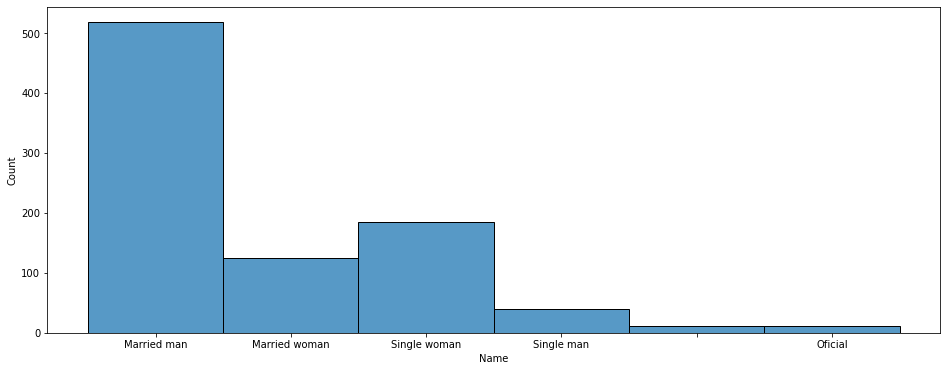

In [187]:
fig, ax = plt.subplots(figsize=(16,6))

display(df.loc[df.Name.apply(getTitle)=='Oficial'])
sns.histplot(df['Name'].apply(getTitle),ax=ax)

In [19]:
Counter(df['Name'].str.split(', ', expand=True)[0])

Counter({'Braund': 2,
         'Cumings': 1,
         'Heikkinen': 1,
         'Futrelle': 2,
         'Allen': 2,
         'Moran': 3,
         'McCarthy': 1,
         'Palsson': 4,
         'Johnson': 6,
         'Nasser': 2,
         'Sandstrom': 2,
         'Bonnell': 1,
         'Saundercock': 1,
         'Andersson': 9,
         'Vestrom': 1,
         'Hewlett': 1,
         'Rice': 5,
         'Williams': 4,
         'Vander Planke': 3,
         'Masselmani': 1,
         'Fynney': 1,
         'Beesley': 1,
         'McGowan': 1,
         'Sloper': 1,
         'Asplund': 4,
         'Emir': 1,
         'Fortune': 4,
         "O'Dwyer": 1,
         'Todoroff': 1,
         'Uruchurtu': 1,
         'Spencer': 1,
         'Glynn': 1,
         'Wheadon': 1,
         'Meyer': 3,
         'Holverson': 2,
         'Mamee': 1,
         'Cann': 1,
         'Nicola-Yarred': 2,
         'Ahlin': 1,
         'Turpin': 2,
         'Kraeff': 1,
         'Laroche': 3,
         'Devaney': 1,
     

In [30]:
df.Cabin.str.len().sort_values(ascending=False)

742    15.0
311    15.0
679    11.0
88     11.0
872    11.0
       ... 
884     NaN
885     NaN
886     NaN
888     NaN
890     NaN
Name: Cabin, Length: 891, dtype: float64

In [201]:
def getCabinsCount(s):
    if isinstance(s, str): t = len(s.split(' '))#.notnull().sum(axis=1)
    else: t = 0
    return t

getCabinsCount('C23 C25 C27')

3

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


<AxesSubplot:xlabel='Cabin', ylabel='Count'>

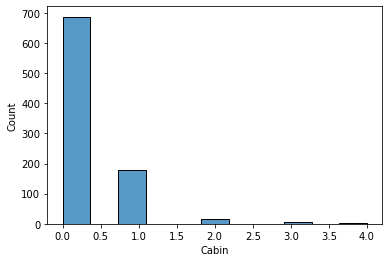

In [200]:
display(df.loc[df.Cabin.apply(getCabinsCount)>1])

sns.histplot(df.Cabin.apply(getCabinsCount))

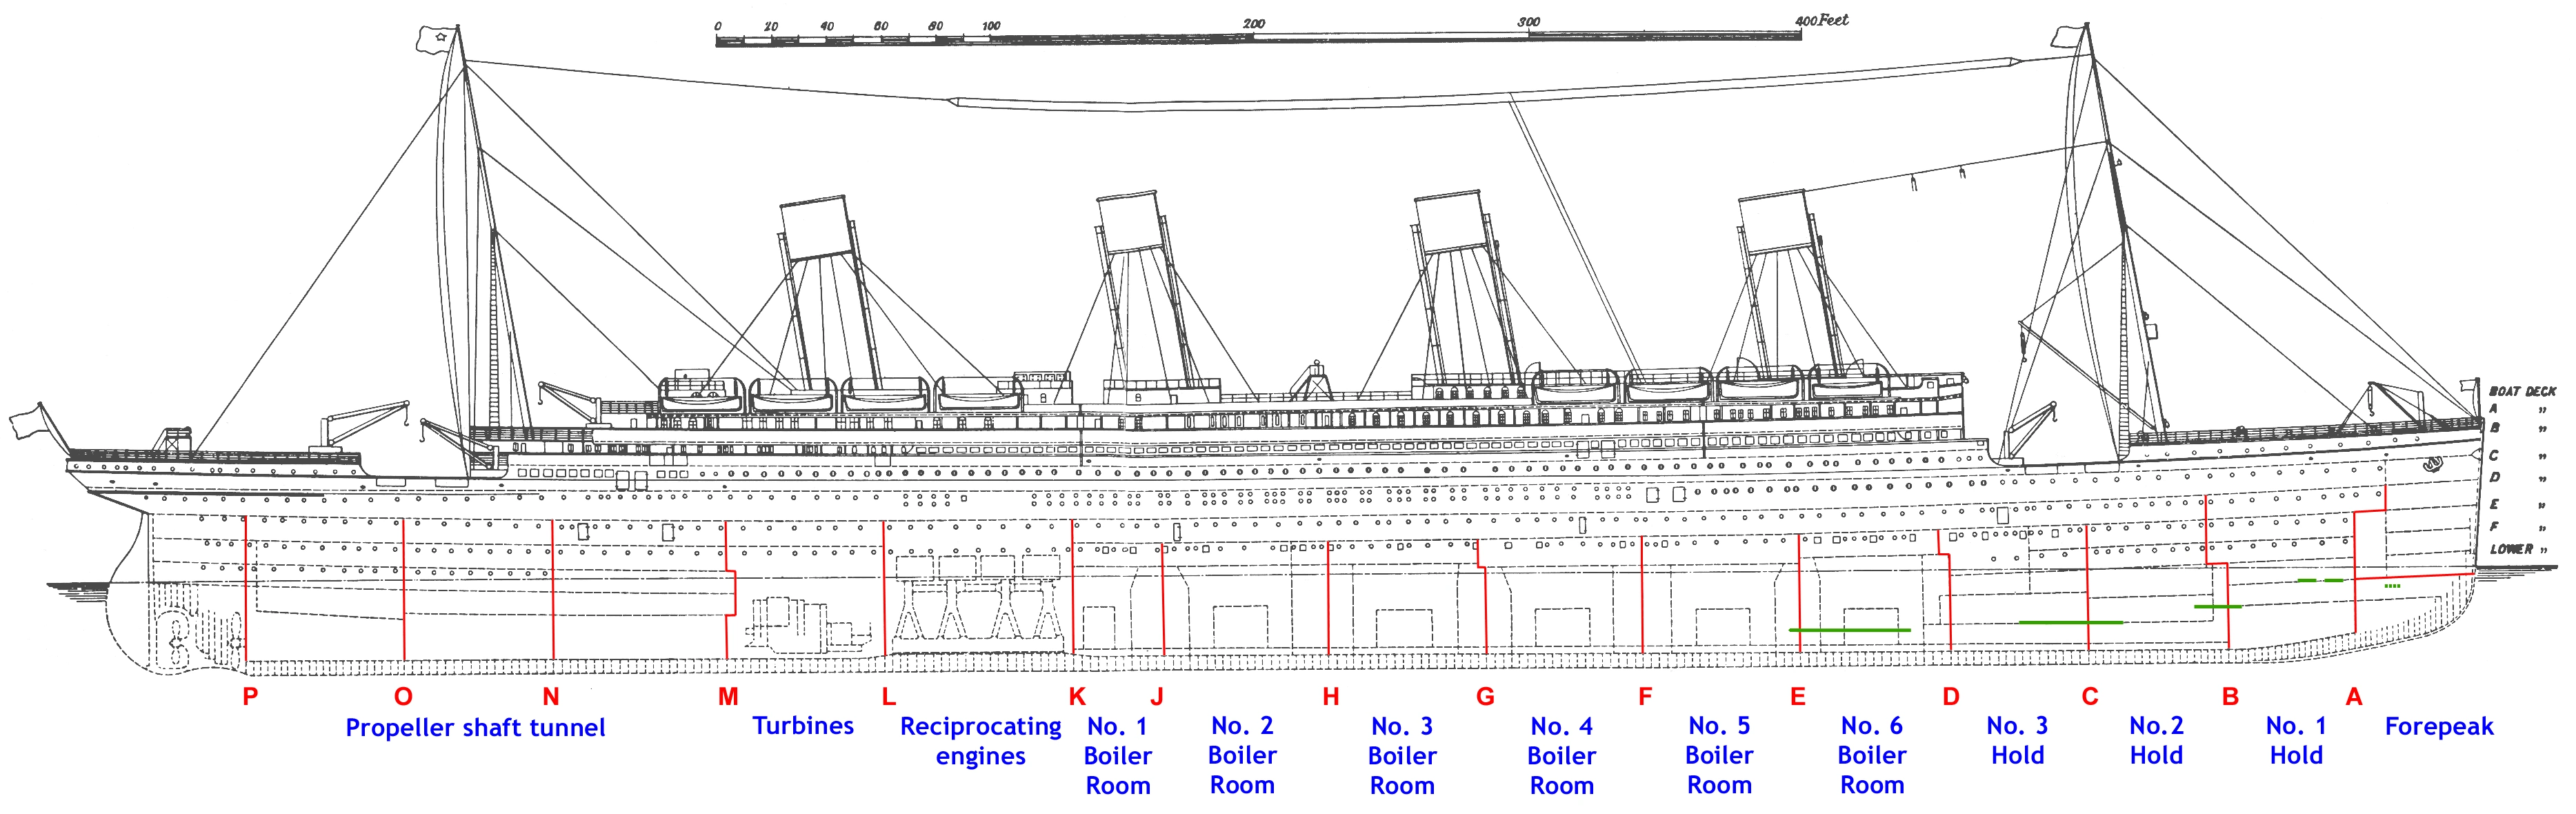

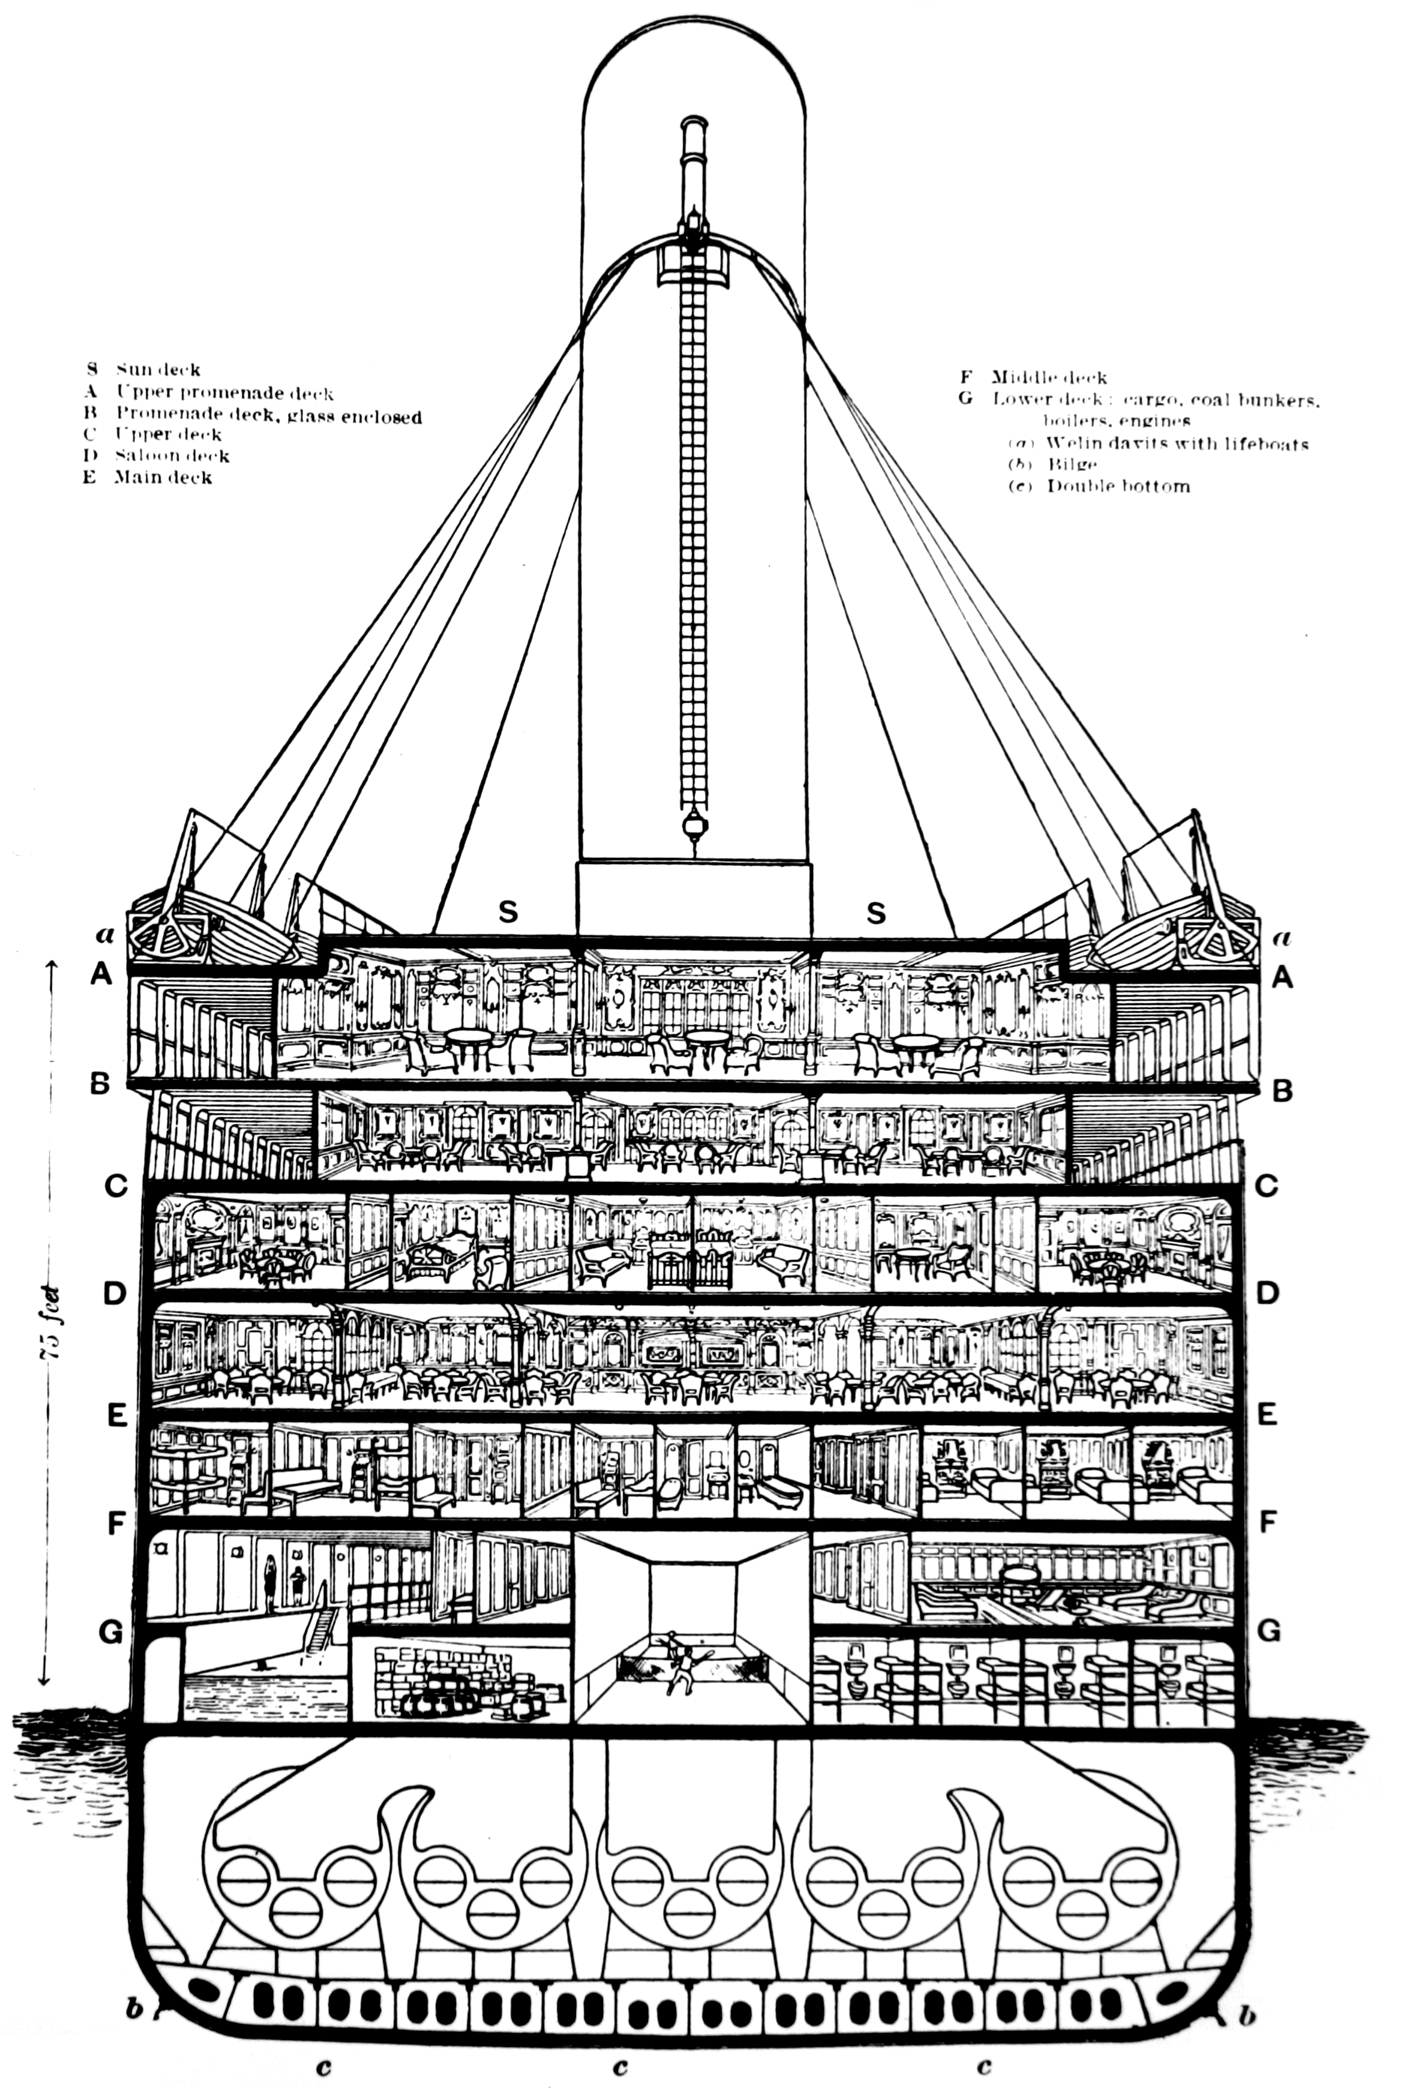

In [287]:
def getCabinsDeck(s):
    if isinstance(s, str): 
        l = s.split(' ')
        x = np.array([(x[0],x[1:]) for x in l])
        t = sorted(x[:,0])[-1]
        
    else: t = 'NA'
    
    return t

def getInt(x):
    try: t = int(x)
    except: t = np.nan
    return t

def getCabinsDeckMaxNumber(s):
    if isinstance(s, str): 
        l = s.split(' ')
        l = np.array([(x[0],x[1:]) for x in l])
        l = l[:,1]
        l = np.array([getInt(x) for x in l])
        l = np.nan_to_num(l,nan=-np.inf)
        t = l[l.argmax()]
        try: t = int(t)
        except: t= -1
        
    else: t = -1
    
    return t



def getCabinsDeckMinNumber(s):
    if isinstance(s, str): 
        l = s.split(' ')
        l = np.array([(x[0],x[1:]) for x in l])
        l = l[:,1]
        l = np.array([getInt(x) for x in l])
        l = np.nan_to_num(l,nan=np.inf)
        t = l[l.argmin()]
        try: t = int(t)
        except: t= -1
        
    else: t = -1
    
    return t


getInt('1'),getCabinsDeck('F G35'), getCabinsDeckMaxNumber('F G35 G40'),getCabinsDeckMinNumber('F G')

(1, 'G', 40, -1)

<AxesSubplot:xlabel='Cabin', ylabel='Count'>

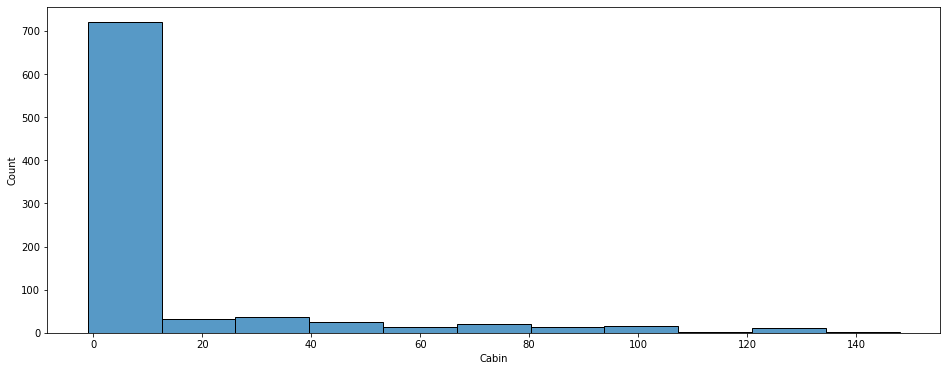

In [288]:
fig, ax = plt.subplots(figsize=(16,6))
#sns.histplot(df.Cabin.apply(getCabinsDeck))
sns.histplot(df.Cabin.apply(getCabinsDeckMaxNumber), ax=ax)

In [59]:
df.Cabin.loc[df.Cabin.str.split(' ',expand=True).notnull().sum(axis=1)>1]

27         C23 C25 C27
75               F G73
88         C23 C25 C27
97             D10 D12
118            B58 B60
128              F E69
297            C22 C26
299            B58 B60
305            C22 C26
311    B57 B59 B63 B66
341        C23 C25 C27
390            B96 B98
435            B96 B98
438        C23 C25 C27
498            C22 C26
679        B51 B53 B55
699              F G63
700            C62 C64
715              F G73
742    B57 B59 B63 B66
763            B96 B98
789            B82 B84
802            B96 B98
872        B51 B53 B55
Name: Cabin, dtype: object

In [61]:
df.loc[df.Cabin.str[0]=='F']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
66,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
183,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0000,F2,S
345,346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S
516,517,1,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
618,619,1,2,"Becker, Miss. Marion Louise",female,4.0,2,1,230136,39.0000,F4,S


In [309]:
def getTicketType(s):
    l = re.findall('([a-zA-Z]+)',s)
    r = ''.join(l).upper()
    return r

def getTicketNumber(s):
    l = re.findall(r'\b\d+\b',s)
    r = ''.join(l).upper()
    return r

def getTicketFrequency(s,s_col):
    l = Counter(s_col.apply(getTicketNumber))
    return l.get(getTicketNumber(s),0)
    
    
getTicketType('C.A. 34260'), getTicketNumber('C.A. 34260'),getTicketFrequency('C.A. 34260',df.Ticket)

('CA', '34260', 1)

<AxesSubplot:xlabel='Ticket', ylabel='Count'>

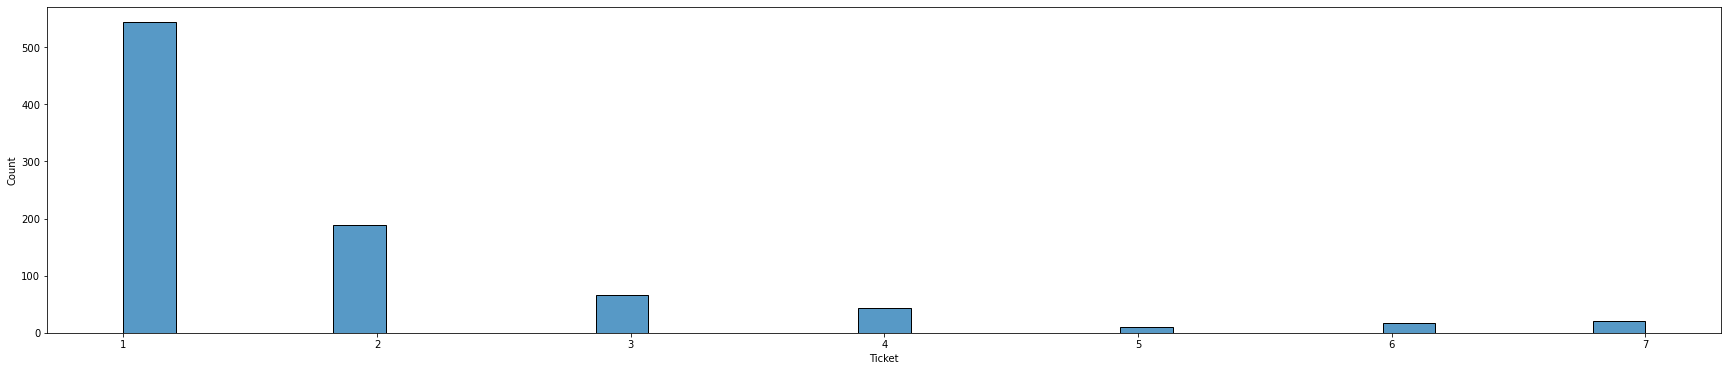

In [310]:
fig, ax = plt.subplots(figsize=(30,6))
sns.histplot(df.Ticket.apply(getTicketFrequency,args=(df.Ticket,)),ax=ax) #.split(' ',expand=True).sample(30)#extract('(\d+)')

In [133]:
#from str import join
df.Ticket.str.findall(r'\b\d+\b').str.join("").value_counts().head(30)

2343       7
347082     7
1601       7
3101295    6
2144       6
347088     6
14879      5
382652     5
349909     4
6608       4
17421      4
17757      4
19950      4
113781     4
4133       4
           4
2666       4
113760     4
347077     4
2123       3
13529      3
248727     3
24160      3
17582      3
34651      3
345773     3
363291     3
17474      3
230080     3
29106      3
Name: Ticket, dtype: int64

In [142]:
df.loc[df.Ticket.str.findall(r'\b\d+\b').str.join("")=='29106']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
407,408,1,2,"Richards, Master. William Rowe",male,3.00,1,1,29106,18.75,NaN,S
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.00,2,3,29106,18.75,NaN,S
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.75,NaN,S


In [ ]:
def heuristic_prediction(X,y,X_test)
    predictions = []

    Xs = X.join(y).copy()
    Xt = X_test.copy()
    
    Xs['Fare'] == Xs['Fare']//10
    Xs['Age'] == Xs['Age']//2
    Xt['Fare'] == Xt['Fare']//10
    Xt['Age'] == Xt['Age']//2
    
    for idx, row in X_test.iterrows():
        data1 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Pclass'] == row['Pclass']]
        data2 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Fare'] == row['Fare']]
        data3 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Age'] == row['Age']]
        if len(data1) and sum(data1)/len(data1) > 0.9:
            predictions.append(1)
        elif len(data2) and sum(data2)/len(data2) > 0.9:
            predictions.append(1)
        elif len(data3) and sum(data3)/len(data3) > 0.9:
            predictions.append(1)
        else:
            predictions.append(0)
    
    return np.array(predictions)

heuristic_predicition(X,y,X_test)